In [1]:
import pandas as pd
from auxiliary.filter_functions import *
from auxiliary.search_algorithm import *
from results import *
from testing import *
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad, SimbadClass
import os
import glob
from astropy.table import Table
import numpy as np
from astropy.io import fits
import time
import matplotlib.pyplot as plt
from astropy.stats import poisson_conf_interval
import scipy
# 2372400

In [2]:
# Get the candidates with no matches within a certain date range

date_range = [
    # '',
    # '2015-01-01',
    '2022-04-01',
    ''
]

no_matches = get_no_match_fxts(20.0, from_date=date_range[0], to_date=date_range[1])
no_matches

,ObsId,RA,DEC,THETA,POS_ERR
8,23488,187.66173433407874,41.6360916527896,2.457,0.08753291125732836
11,28964,244.71649522184907,-1.991866011802935,6.134,0.360551429526109


In [3]:
# plot the light curves of the candidates with no matches
# for i, fxt in no_matches.iterrows():
#     plot_light_curve(
#         fxt['ObsId'],
#         float(fxt['RA']),
#         float(fxt['DEC']),
#         float(fxt['THETA']),
#     )

In [4]:
# get the criteria table for a certain date range like in the papers

date_range = [
    # '',
    # '2015-01-01',
    '2022-04-01',
    ''
]

criteria_table = get_criteria_table(from_date=date_range[0], to_date=date_range[1])

criteria_table

,Matched,Unique Matched,Removed,Remaining
Archival X-ray date,20,2,20,25
Cross-match with stars/Gaia,28,10,19,6
NED + SIMBAD + VizieR,20,2,4,2


In [5]:
# get table of number of observations, analysed observations, detections and no match detections

date_range = [
    # '',
    # '2015-01-01',
    '2022-04-01',
    ''
]

candidate_numbers = get_candidate_numbers(
    from_date=date_range[0], to_date=date_range[1])

candidate_numbers

,Total,Before,In,After
Observations,9799,8303,NaN,1496
Analysed,9633,8137,NaN,1496
Detections,1283,1238,NaN,45
Candidates no match,79,77,NaN,2


In [6]:
# generate and save random light curves to manually check detections

# random_detections, random_light_curves = get_random_light_curves(50, from_date='', to_date='')
# plot_random_light_curves(random_detections, random_light_curves)

In [7]:
# test a filter function on a given detection

obsid = 8490
detections = get_detections(
    str(obsid),
    ra='',
    dec=''
)[0:1]

for index, detection in detections.iterrows():
    print(index, filter_Xray_binaries(detection, True))

  ID           Name          RAJ2000   DEJ2000    Flux    b_Flux   B_Flux  Flagp Flagu Flagn    c       LX      b_LX     B_LX  
                               deg       deg    mW / m2  mW / m2  mW / m2                            1e-07 W  1e-07 W  1e-07 W 
----- --------------------- --------- --------- -------- -------- -------- ----- ----- ----- ------- -------- -------- --------
46957 2CXO J132458.3-430226 201.24330 -43.04060        0        0 9.78e-17     0     1     0 0.50004        0        0 1.45e+35
220 True


	q1 + q2: 27
	q3 + q4: 4
	q1 + q4: 19
	q2 + q3: 12
8490 - RA: 201.243, DEC: -43.041 - full


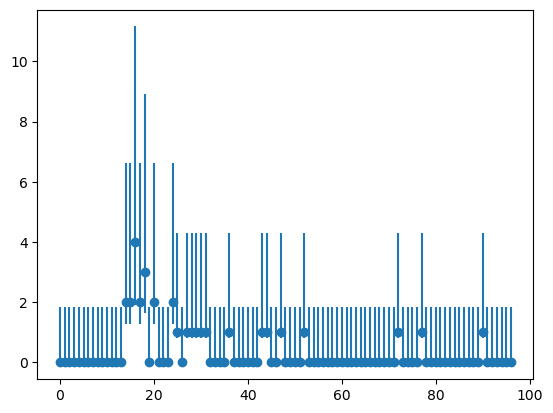

In [8]:
# test search algorithm for a single source

obsid = 8490
detections = get_detections(
    str(obsid),
    ra='',
    dec=''
)[0:1]

# or manually give source
# to check fxt in paper for example

# detections = pd.DataFrame({
#     'ObsId': ['24604'],
#     'RA': ['207.23523'],
#     'DEC': ['26.66230'],
#     'THETA': ['7.08']
# })

for index, detection in detections.iterrows():
    test_search_algorithm(
        detection['ObsId'],
        float(detection['RA']),
        float(detection['DEC']),
        float(detection['THETA'])
    )
    lc = gen_light_curve(
        detection['ObsId'],
        float(detection['RA']),
        float(detection['DEC']),
        float(detection['THETA'])
    )
    plt.errorbar(
        (lc['time'] - lc['time'][0]) / 1000,
        lc['counts'],
        yerr=[lc['error_low'], lc['error_high']],
        fmt='o'
    )
    plt.show()

In [9]:
# check if fxts from papers are found in new code
paper_I_fxts = [
    [803, 186.38125, 13.06607],
    [2025, 167.86792, 55.67253],
    [8490, 201.24329, -43.04060],
    [9546, 211.25113, 53.65706],
    [9548, 170.07296, 12.97189],
    [14904, 345.49250, 15.94871],
    [4062, 76.77817, -31.86980],
    [5885, 318.12646, -63.49914],
    [9841, 175.00504, -31.91743],
    [12264, 90.00450, -52.71501],
    [12884, 212.12063, -27.05784],
    [13454, 15.93558, -21.81272],
    [15113, 45.26725, -77.88095],
    [16454, 53.16158, -27.85940],
]

paper_II_fxts = [
    [16093, 233.73496, 23.46849],
    [16453, 53.07672, -27.87345],
    [18715, 40.82972, 32.32390],
    [19310, 36.71489, -1.08317],
    [20635, 356.26437, -42.64494],
    [21831, 207.34711, 26.58421 ],
    [23103, 50.47516, 41.24704],
    [24604, 207.23523, 26.66230],
]

analysed = pd.read_csv('output/analysed_w20.txt', header=0, sep=' ', dtype=str)

print('Paper I FXTs')
for fxt in paper_I_fxts:
    detections = get_detections(str(fxt[0]), fxt[1], fxt[2], True)
    if not detections.empty:
        print(detections[['ObsId', 'RA', 'DEC']].to_string(index=False, header=False))
    elif not analysed[analysed['ObsId'] == str(fxt[0])].empty:
        print(f'{fxt[0]} - not detected')
    else:
        print(f'{fxt[0]} - not analysed')

print('Paper II FXTs')
for fxt in paper_II_fxts:
    detections = get_detections(str(fxt[0]), fxt[1], fxt[2], True)
    if not detections.empty:
        print(detections[['ObsId', 'RA', 'DEC']].to_string(index=False, header=False))
    elif not analysed[analysed['ObsId'] == str(fxt[0])].empty:
        print(f'{fxt[0]} - not detected')
    else:
        print(f'{fxt[0]} - not analysed')
        

Paper I FXTs
803 186.381579 13.066452
2025 167.86794 55.672528
8490 201.24335 -43.040584
9546 211.251125 53.65706
9548 170.072881 12.971883
14904 345.492502 15.948704
4062 76.778177 -31.86982
5885 318.126599 -63.49898
9841 175.005028 -31.917419
12264 90.004429 -52.715044
12884 212.120467 -27.057995
13454 15.935694 -21.812707
15113 45.268361 -77.880922
16454 53.161632 -27.859487
Paper II FXTs
16093 233.734807 23.468395
16453 53.076762 -27.873612
18715 40.829608 32.323772
19310 - not analysed
20635 356.264589 -42.644933
21831 207.347187 26.584447
23103 50.47529 41.246834
24604 - not detected
